In [1]:
# Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий 
# в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен A/B тест: тестовой группе 
# предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. 
# Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных 
# пользователей.

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

import seaborn as sns

In [4]:
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials
from io import StringIO
import requests

In [5]:
# информация о пользователях, которые посещали приложение во время эксперимента
orig_url='https://drive.google.com/file/d/1hdoV7snC67CyPSZac-O5H3Z7JfTTeO8g/view?usp=sharing'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
active_users = pd.read_csv(csv_raw)
active_users.head()

user_id country platform     sex
0     8029  Russia      ios    male
1     1735  Sweden      ios    male
2     7697  Russia  android    male
3     1421  Sweden  android  female
4     1704  Russia      ios    male

In [6]:
# разбивка пользователей на контрольную (А) и тестовую (В) группы
orig_url='https://drive.google.com/file/d/1ZY0WPBvUqRwCaZubISwk5dmoaMQIRkSs/view?usp=sharing'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
groups = pd.read_csv(csv_raw)
groups.head()

user_id group
0     9149     B
1     9150     B
2     9151     A
3     9152     B
4     9153     B

In [7]:
# данные о транзакциях (оплатах) пользователей приложения во время эксперимента
orig_url='https://drive.google.com/file/d/1pXJahrYmG1LQwBNiX0131-B2qaieRShZ/view?usp=sharing'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
purchases = pd.read_csv(csv_raw)
purchases.head()

user_id  revenue
0     4412   1000.0
1     9000    701.0
2     9001    700.0
3     9002    702.0
4     5790   1002.0

In [5]:
purchases.shape

(541, 2)

In [ ]:
#объединяем таблицу с информацией о покупках и информацией об зарегистрированных пользователях так, 
# чтобы информация о покупателях без регистрации не потерялась:

In [6]:
users_purchases = active_users.merge(purchases, how='outer', on='user_id') 

In [7]:
users_purchases.shape

(8490, 5)

In [8]:
users_purchases.shape

(8490, 5)

In [9]:
active_users.shape

(8341, 4)

In [ ]:
#добавляем к users_purchases разбивку на группы:

In [10]:
total=users_purchases.merge(groups, how='left', on='user_id')

In [27]:
total.head()

user_id country platform     sex  revenue group
0     8029  Russia      ios    male      NaN     B
1     1735  Sweden      ios    male      NaN     B
2     7697  Russia  android    male      NaN     B
3     1421  Sweden  android  female      NaN     B
4     1704  Russia      ios    male      NaN     B

In [11]:
total.group.isna().sum()

0

In [12]:
total.groupby('group', as_index=False).agg({'revenue' : 'mean'}) # смотрим среднее значение по группам

group      revenue
0     A   870.672897
1     B  1118.836406

In [13]:
total.groupby('group', as_index=False).agg({'revenue' : 'median'}) #смотрим значение медианы по группам

group  revenue
0     A    698.0
1     B    944.0

In [14]:
total.revenue.count()

541

In [15]:
total.query("group == 'A'").user_id.count()

1567

In [18]:
group_A = total.query("group == 'A'").revenue.fillna(0) # вытаскиваем revenue группы А, заменяем NaN на 0

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


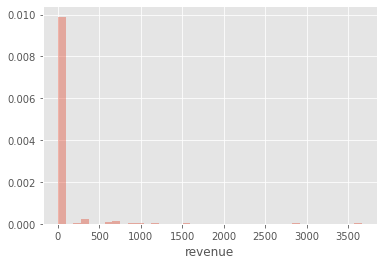

In [19]:
sns.distplot(group_A) # смотрим распределение 

In [20]:
group_B = total.query("group == 'B'").revenue.fillna(0) # вытаскиваем revenue группы B, заменяем NaN на 0

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


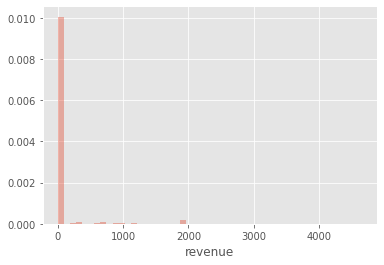

In [21]:
sns.distplot(group_B) # смотрим распределение 

In [ ]:
# распределение отличное от нормального, для проверки гипотезы применим бутстрап для средних значений 
# (медианы будут равны нулю в большинстве случаев)

In [49]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [22]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрап-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = group_A.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = group_B.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

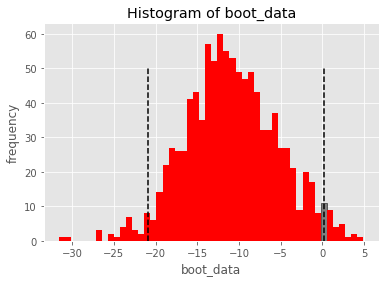

In [23]:
booted_data = get_bootstrap(group_A, group_B) # в результате хранится разница двух распределений, ДИ и pvalue

In [24]:
booted_data["p_value"]

0.049108577614969375

In [25]:
booted_data["quants"] # ДИ

0
0.025 -20.932984
0.975   0.247765

In [26]:
# Почти все бутсрап-распределение красное, P_value=0,05, т.е распределение не согласуется с нулевой гипотезой.

In [ ]:
# ОТклоняем нулевую гипотезу, различия являются значимыми. Принимаем решение выкатить модель на остальных пользователей.